In [350]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.auto import tqdm
sns.set_style('whitegrid')

# Import Data

In [351]:
rawdata_df = pd.read_csv('../temp/2782e4581854eb9b.csv')

In [352]:
rawdata_df.head()

,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,TR_SCOND,SIZE,PRICE,TR_CORR,TR_SEQNUM,TR_ID,TR_SOURCE,TR_RF
0,20200511,8:03:46.118411997,D,SPSB,NaN,C TI,1,30.91,0,1013601,71675223164488,C,T
1,20200511,8:11:50.715316011,D,SPSB,NaN,C TI,1,30.91,0,1129401,71675223290187,C,T
2,20200511,8:49:09.639653435,K,SPSB,NaN,T,235,30.91,0,1563801,52983525036897,C,NaN
3,20200511,9:30:00.155812463,P,SPSB,NaN,O,7483,30.92,0,2209201,52983525230914,C,NaN
4,20200511,9:30:00.155822966,P,SPSB,NaN,Q,7483,30.92,0,2209301,52983525230915,C,NaN


# Prep Data

In [353]:
data_df_d = rawdata_df.query('EX == "D"').copy()
data_df = rawdata_df.query('EX != "D"').copy()

In [354]:
# Add datetime info
data_df['DATE TIME'] = data_df['DATE'].astype(str) + ' ' + data_df['TIME_M'].astype(str)
data_df['datetime'] = pd.to_datetime(data_df['DATE TIME'])
data_df['date'] = pd.to_datetime(data_df['DATE'].astype(str))

data_df_d['DATE TIME'] = data_df_d['DATE'].astype(str) + ' ' + data_df_d['TIME_M'].astype(str)
data_df_d['datetime'] = pd.to_datetime(data_df_d['DATE TIME'])
data_df_d['date'] = pd.to_datetime(data_df_d['DATE'].astype(str))

In [355]:
data_df['ticker'] = data_df['SYM_ROOT']
data_df['log_price'] = np.log(data_df['PRICE'])

In [356]:
# Resample on a given basis
data_df = (
    data_df.set_index("datetime")
    .groupby(["ticker", "date"])
    .resample('1s')["log_price"]
    .last()
    .reset_index()
)


data_df["log_price"] = (
    data_df.sort_values(by="datetime")
    .groupby(["ticker", "date"])["log_price"]
    .fillna(method="ffill")
)

In [357]:
data_df = data_df.sort_values(by="datetime")
data_df["return"] = data_df.groupby(["ticker", "date"])["log_price"].diff(1)

In [361]:
data_df['return_squared'] = np.square(data_df['return'])

In [384]:
data_df["RV_5s"] = (
    data_df.groupby(["ticker", "date"])["return_squared"].rolling(5).sum().reset_index([0, 1], drop=True)
)

# Main

In [386]:
data_df_d.query('DATE == 20200519').query('SIZE > 100000')

,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,TR_SCOND,SIZE,PRICE,TR_CORR,TR_SEQNUM,TR_ID,TR_SOURCE,TR_RF,DATE TIME,datetime,date
27112,20200519,11:35:04.920051822,D,SPSB,NaN,NaN,110922,31.06,0,30994201,71679905182801,C,T,20200519 11:35:04.920051822,2020-05-19 11:35:04.920051822,2020-05-19
29576,20200519,15:35:00.434800438,D,SPSB,NaN,NaN,230553,31.06,0,67815801,71688478087472,C,T,20200519 15:35:00.434800438,2020-05-19 15:35:00.434800438,2020-05-19


In [387]:
fed_trade_datetime_1 = data_df_d.query('SIZE == 110922')['datetime'].values[0]
fed_trade_datetime_2 = data_df_d.query('SIZE == 230553')['datetime'].values[0]

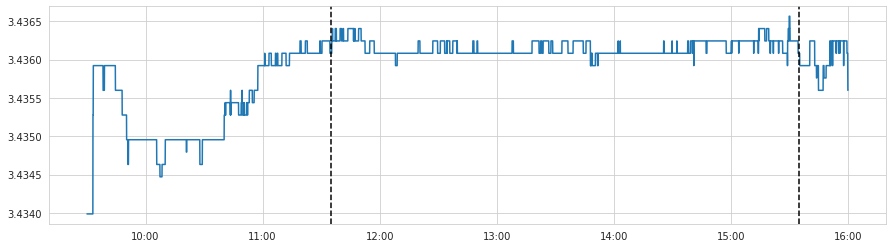

In [388]:
start_time = pd.to_datetime('20200519 09:30:00')
end_time = pd.to_datetime('20200519 16:00:00')
sample_data_df = data_df.loc[(data_df['datetime'] >= start_time) & (data_df['datetime'] <= end_time), :]

fig, ax = plt.subplots(figsize = (15,4))
plt.plot('datetime', 'log_price', data = sample_data_df)
plt.axvline(fed_trade_datetime_1, color = 'k', ls = '--')
plt.axvline(fed_trade_datetime_2, color = 'k', ls = '--')

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M"))

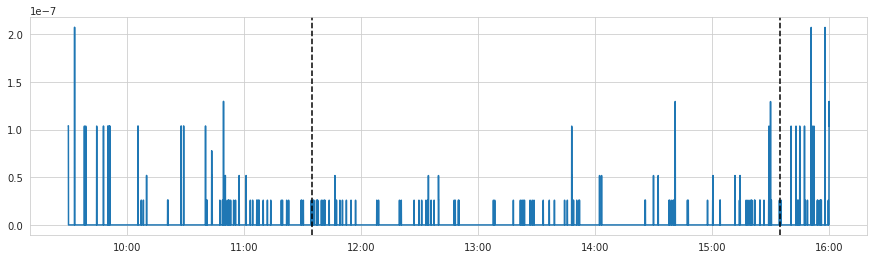

In [389]:
start_time = pd.to_datetime('20200519 09:30:00')
end_time = pd.to_datetime('20200519 16:00:00')
sample_data_df = data_df.loc[(data_df['datetime'] >= start_time) & (data_df['datetime'] <= end_time), :].query('RV_5s < 0.000001')

fig, ax = plt.subplots(figsize = (15,4))
plt.plot('datetime', 'RV_5s', data = sample_data_df)
plt.axvline(fed_trade_datetime_1, color = 'k', ls = '--')
plt.axvline(fed_trade_datetime_2, color = 'k', ls = '--')

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M"))

In [393]:
def RV_event(data_df, event_datetime, RV_varname, event_window = int(30*60)):
    # Gets RV before and after an event; event window is the number (int) of seconds 
    # before and after to consider
    
    # Boolean series indicating when trade occurred
    after_datetime_min = data_df["datetime"] >= (event_datetime - pd.Timedelta(str(event_window) + "s"))
    after_datetime_mid = data_df["datetime"] >= event_datetime
    after_datetime_max = data_df["datetime"] >= (event_datetime + pd.Timedelta(str(event_window) + "s"))

    RV_before = data_df.loc[(after_datetime_min & (~after_datetime_mid)), RV_varname]
    RV_after = data_df.loc[(~after_datetime_max & (after_datetime_mid)), RV_varname]

    return (np.mean(RV_before), np.mean(RV_after))

In [394]:
RV_event(data_df, fed_trade_datetime_2, 'RV_5s')

(2.2300956025919103e-09, 4.390234183588595e-09)